In [1]:
import pandas as pd
import os
from pandas import read_csv
from pandas import read_parquet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pyarrow
import fastparquet
from datetime import datetime, timezone, timedelta
import scipy.stats as s

warnings.filterwarnings("ignore")

work_dir = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/BILD-AQ/data'
os.chdir(work_dir)

selected_state = 'HI'
plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font
meter_to_mile = 0.000621371

In [2]:
# bildaq_od_data = read_csv('Output/' + selected_state+ '/OD_summary_with_routed_distance.csv')
# NHTS_od_data = read_csv('Network/' + selected_state+ '/NHTS_car_trips_CA.csv' )
dist_matrix_file = 'distance_matrix_by_tracts.csv'
cut_off = 100
dist_matrix = pd.read_csv('Network/' + selected_state + '/' + dist_matrix_file, sep = ',')
dist_matrix = dist_matrix.rename(columns = {'Unnamed: 0': 'origin'})
dist_matrix_long = pd.melt(dist_matrix, id_vars = 'origin', 
                        var_name = 'destination', value_name = 'distance')
dist_matrix_long = dist_matrix_long.loc[dist_matrix_long['distance'] <= cut_off]
print(len(dist_matrix_long))

inrix_file = selected_state + '_travel_time.csv'
inrix_travel_time = pd.read_csv('Network/' + selected_state + '/' + inrix_file, sep = ',')
inrix_travel_time.loc[:, 'avg_speed'] = inrix_travel_time.loc[:, 'distance_mile'] / \
inrix_travel_time.loc[:, 'travel_time_h']

inrix_travel_time.loc[inrix_travel_time['avg_speed']>= 80, 'avg_speed'] = 80
print(len(inrix_travel_time))
inrix_travel_time.head(5)

74193
50649


,o_GEOID,d_GEOID,distance_mile,travel_time_h,trip_count,avg_speed
0,15001020100,15001020100,3.578036,0.163904,2714,21.830013
1,15001020100,15001020202,8.167861,0.303816,137,26.884247
2,15001020100,15001020300,10.050680,0.358335,1090,28.048290
3,15001020100,15001020400,9.333257,0.332216,568,28.093954
4,15001020100,15001020500,11.154491,0.408708,467,27.292074


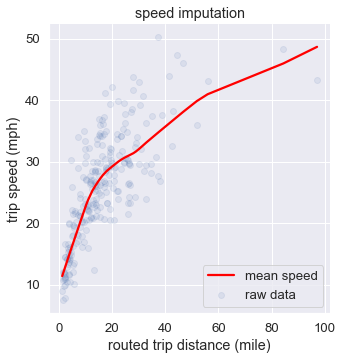

In [3]:
sample_inrix_travel_time = inrix_travel_time.sample(frac = 0.005)
sample_inrix_travel_time = sample_inrix_travel_time[sample_inrix_travel_time['distance_mile'] <= 100]
sns.lmplot(x="distance_mile", y="avg_speed",  
           data=sample_inrix_travel_time, lowess=True, 
           scatter_kws={'alpha':0.1},
           line_kws={'color': 'red'})
# plt.xlim([0,100])
plt.xlabel('routed trip distance (mile)')
plt.ylabel('trip speed (mph)')
plt.legend(['mean speed', 'raw data'])
plt.title('speed imputation')

plt.show()

In [4]:
dist_matrix_long[['origin', 'destination']] = \
dist_matrix_long[['origin', 'destination']].astype(int)
inrix_travel_time[['o_GEOID', 'd_GEOID']] = \
inrix_travel_time[['o_GEOID', 'd_GEOID']].astype(int)

dist_and_time_matrix = pd.merge(dist_matrix_long, 
                                inrix_travel_time, 
                                left_on = ['origin', 'destination'],
                                right_on = ['o_GEOID', 'd_GEOID'],
                                how = 'left')
dist_and_time_matrix.head(5)

,origin,destination,distance,o_GEOID,d_GEOID,distance_mile,travel_time_h,trip_count,avg_speed
0,15001020702,15001020702,0.000000,1.500102e+10,1.500102e+10,3.876274,0.216083,346.0,17.938818
1,15001021502,15001020702,46.228310,1.500102e+10,1.500102e+10,73.075950,1.369097,4.0,53.375282
2,15001020202,15001020702,10.438396,1.500102e+10,1.500102e+10,6.609668,0.325853,14.0,20.284191
3,15001020400,15001020702,2.680404,1.500102e+10,1.500102e+10,4.171556,0.214721,167.0,19.427837
4,15001020600,15001020702,4.092597,1.500102e+10,1.500102e+10,4.249380,0.230584,523.0,18.428795


In [5]:
import statsmodels.api as sm
dist_and_time_matrix_train = dist_and_time_matrix.dropna()
X = dist_and_time_matrix_train['distance']
y = dist_and_time_matrix_train['distance_mile']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:          distance_mile   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                 3.644e+05
Date:                Wed, 08 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:12:46   Log-Likelihood:            -1.4328e+05
No. Observations:               50649   AIC:                         2.866e+05
Df Residuals:                   50647   BIC:                         2.866e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0538      0.031     34.062      0.0

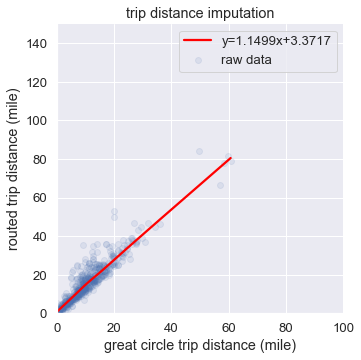

In [6]:
sample_inrix_travel_time_train = dist_and_time_matrix_train.sample(frac = 0.01)
sns.lmplot(x="distance", y="distance_mile",  
           data = sample_inrix_travel_time_train, lowess=True, 
           scatter_kws={'alpha':0.1},
           line_kws={'color': 'red'})
plt.xlim([0,100])
plt.ylim([0,150])
plt.xlabel('great circle trip distance (mile)')
plt.ylabel('routed trip distance (mile)')
plt.legend(['y=1.1499x+3.3717', 'raw data'])
plt.title('trip distance imputation')

plt.show()

In [7]:
dist_and_time_matrix_train.loc[:, 'distance_bin'] = \
dist_and_time_matrix_train.loc[:, 'distance_mile'].astype(int)
mean_speed_lookup = \
dist_and_time_matrix_train.groupby('distance_bin')[['avg_speed']].mean()
mean_speed_lookup = mean_speed_lookup.reset_index()
mean_speed_lookup.head(5)

,distance_bin,avg_speed
0,0,8.516124
1,1,10.578557
2,2,12.412234
3,3,14.184822
4,4,15.942941


In [8]:
dist_and_time_matrix_to_fill = dist_and_time_matrix[dist_and_time_matrix.isna().any(axis=1)]
dist_and_time_matrix_to_fill.head(5)
dist_and_time_matrix_to_fill.loc[:, 'distance_mile'] = \
1.4130 * dist_and_time_matrix_to_fill.loc[:, 'distance'] + 1.0538

dist_and_time_matrix_to_fill.loc[:, 'distance_bin'] = \
dist_and_time_matrix_to_fill.loc[:, 'distance_mile'].astype(int)

dist_and_time_matrix_to_fill = dist_and_time_matrix_to_fill.drop(columns=['avg_speed'])
dist_and_time_matrix_to_fill = pd.merge(dist_and_time_matrix_to_fill,
                                        mean_speed_lookup,
                                        on = 'distance_bin',
                                        how = 'left')

In [9]:

max_speed = mean_speed_lookup.avg_speed.max()
print(max_speed)
dist_and_time_matrix_to_fill.loc[:, 'avg_speed'] = \
dist_and_time_matrix_to_fill.loc[:, 'avg_speed'].fillna(max_speed)
dist_and_time_matrix_to_fill.loc[:, 'travel_time_h'] = \
dist_and_time_matrix_to_fill.loc[:, 'distance_mile'] / \
dist_and_time_matrix_to_fill.loc[:, 'avg_speed']
dist_and_time_matrix_to_fill.head(5)

47.37212999337335


,origin,destination,distance,o_GEOID,d_GEOID,distance_mile,travel_time_h,trip_count,distance_bin,avg_speed
0,15001990300,15001020702,22.308036,NaN,NaN,32.575055,0.927639,NaN,32,35.116093
1,15001021402,15001020702,54.129594,NaN,NaN,77.538916,1.640151,NaN,77,47.275467
2,15009030100,15001020702,99.495888,NaN,NaN,141.641490,2.989975,NaN,141,47.372130
3,15009030901,15001021502,98.974255,NaN,NaN,140.904422,2.974416,NaN,140,47.372130
4,15009990200,15001021502,93.370326,NaN,NaN,132.986071,2.807264,NaN,132,47.372130


In [10]:
output_attr = ['origin', 'destination',	'distance',	 'distance_mile',  'travel_time_h', 'avg_speed']
dist_and_time_matrix_to_fill = dist_and_time_matrix_to_fill[output_attr]
dist_and_time_matrix_train = dist_and_time_matrix_train[output_attr]
dist_and_time_matrix_out = pd.concat([dist_and_time_matrix_to_fill, 
                                      dist_and_time_matrix_train])
print(sum(dist_and_time_matrix_out.isna().any(axis=1)))
dist_and_time_matrix_out.head(5)


0


,origin,destination,distance,distance_mile,travel_time_h,avg_speed
0,15001990300,15001020702,22.308036,32.575055,0.927639,35.116093
1,15001021402,15001020702,54.129594,77.538916,1.640151,47.275467
2,15009030100,15001020702,99.495888,141.641490,2.989975,47.372130
3,15009030901,15001021502,98.974255,140.904422,2.974416,47.372130
4,15009990200,15001021502,93.370326,132.986071,2.807264,47.372130


In [11]:
dist_and_time_matrix_out.to_csv('Network/' + selected_state + '/travel_time_skim.csv')

In [12]:
dist_and_time_matrix_check = dist_and_time_matrix_out[dist_and_time_matrix_out.isna().any(axis=1)]
dist_and_time_matrix_check.head(5)
print(sum(dist_and_time_matrix_out.isna().any(axis=1)))

0
